In [1]:
import torch
import torch.nn as nn
from spikingjelly.activation_based import neuron, layer, learning
from matplotlib import pyplot as plt
torch.manual_seed(0)


/data/tanghao/miniconda3/envs/py38/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def f_pre(x, w_min, alpha=0.):
    return (x - w_min) ** alpha

def f_post(x, w_max, alpha=0.):
    return (w_max - x) ** alpha

In [3]:
w_min, w_max = -1., 1.
tau_pre, tau_post = 2., 2.
N_in, N_out = 4, 3
T = 128
batch_size = 2
lr = 0.01
net = nn.Sequential(
    layer.Linear(N_in, N_out, bias=False),
    neuron.IFNode()
)
nn.init.constant_(net[0].weight.data, 0.4)

tensor([[0.4000, 0.4000, 0.4000, 0.4000],
        [0.4000, 0.4000, 0.4000, 0.4000],
        [0.4000, 0.4000, 0.4000, 0.4000]])

In [4]:
optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.)

In [5]:
in_spike = (torch.rand([T, batch_size, N_in]) > 0.7).float()
learner = learning.STDPLearner(step_mode='s', synapse=net[0], sn=net[1],
                               tau_pre=tau_pre, tau_post=tau_post,
                               w_min=w_min, w_max=w_max,
                               f_pre=f_pre, f_post=f_post)


In [6]:
out_spike = []
trace_pre = []
trace_post = []
weight = []
with torch.no_grad():
    for t in range(T):
        optimizer.zero_grad()
        out_spike.append(net(in_spike[t]))
        learner.step(on_grad=True)
        optimizer.step()
        net[0].weight.data.clamp_(w_min, w_max)
        weight.append(net[0].weight.data.clone())
        trace_pre.append(learner.trace_pre)
        trace_post.append(learner.trace_post)

out_spike = torch.stack(out_spike)   # [T, batch_size, N_out]
trace_pre = torch.stack(trace_pre)   # [T, batch_size, N_in]
trace_post = torch.stack(trace_post) # [T, batch_size, N_out]
weight = torch.stack(weight)         # [T, N_out, N_in]

t = torch.arange(0, T).float()

in_spike = in_spike[:, 0, 0]
out_spike = out_spike[:, 0, 0]
trace_pre = trace_pre[:, 0, 0]
trace_post = trace_post[:, 0, 0]
weight = weight[:, 0, 0]

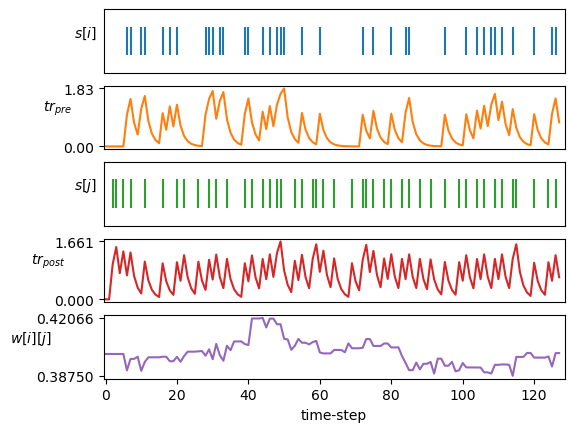

In [7]:
cmap = plt.get_cmap('tab10')
plt.subplot(5, 1, 1)
plt.eventplot((in_spike * t)[in_spike == 1], lineoffsets=0, colors=cmap(0))
plt.xlim(-0.5, T + 0.5)
plt.ylabel('$s[i]$', rotation=0, labelpad=10)
plt.xticks([])
plt.yticks([])

plt.subplot(5, 1, 2)
plt.plot(t, trace_pre, c=cmap(1))
plt.xlim(-0.5, T + 0.5)
plt.ylabel('$tr_{pre}$', rotation=0)
plt.yticks([trace_pre.min().item(), trace_pre.max().item()])
plt.xticks([])

plt.subplot(5, 1, 3)
plt.eventplot((out_spike * t)[out_spike == 1], lineoffsets=0, colors=cmap(2))
plt.xlim(-0.5, T + 0.5)
plt.ylabel('$s[j]$', rotation=0, labelpad=10)
plt.xticks([])
plt.yticks([])

plt.subplot(5, 1, 4)
plt.plot(t, trace_post, c=cmap(3))
plt.ylabel('$tr_{post}$', rotation=0)
plt.yticks([trace_post.min().item(), trace_post.max().item()])
plt.xlim(-0.5, T + 0.5)
plt.xticks([])

plt.subplot(5, 1, 5)
plt.plot(t, weight, c=cmap(4))
plt.xlim(-0.5, T + 0.5)
plt.ylabel('$w[i][j]$', rotation=0)
plt.yticks([weight.min().item(), weight.max().item()])
plt.xlabel('time-step')

plt.gcf().subplots_adjust(left=0.18)

plt.show()